Creating wildfire CHM comparison visualization...
------------------------------------------------------------

LOADING CHM DATA

Loading Palisades Fire CHMs...
Loading Eaton Fire CHMs...


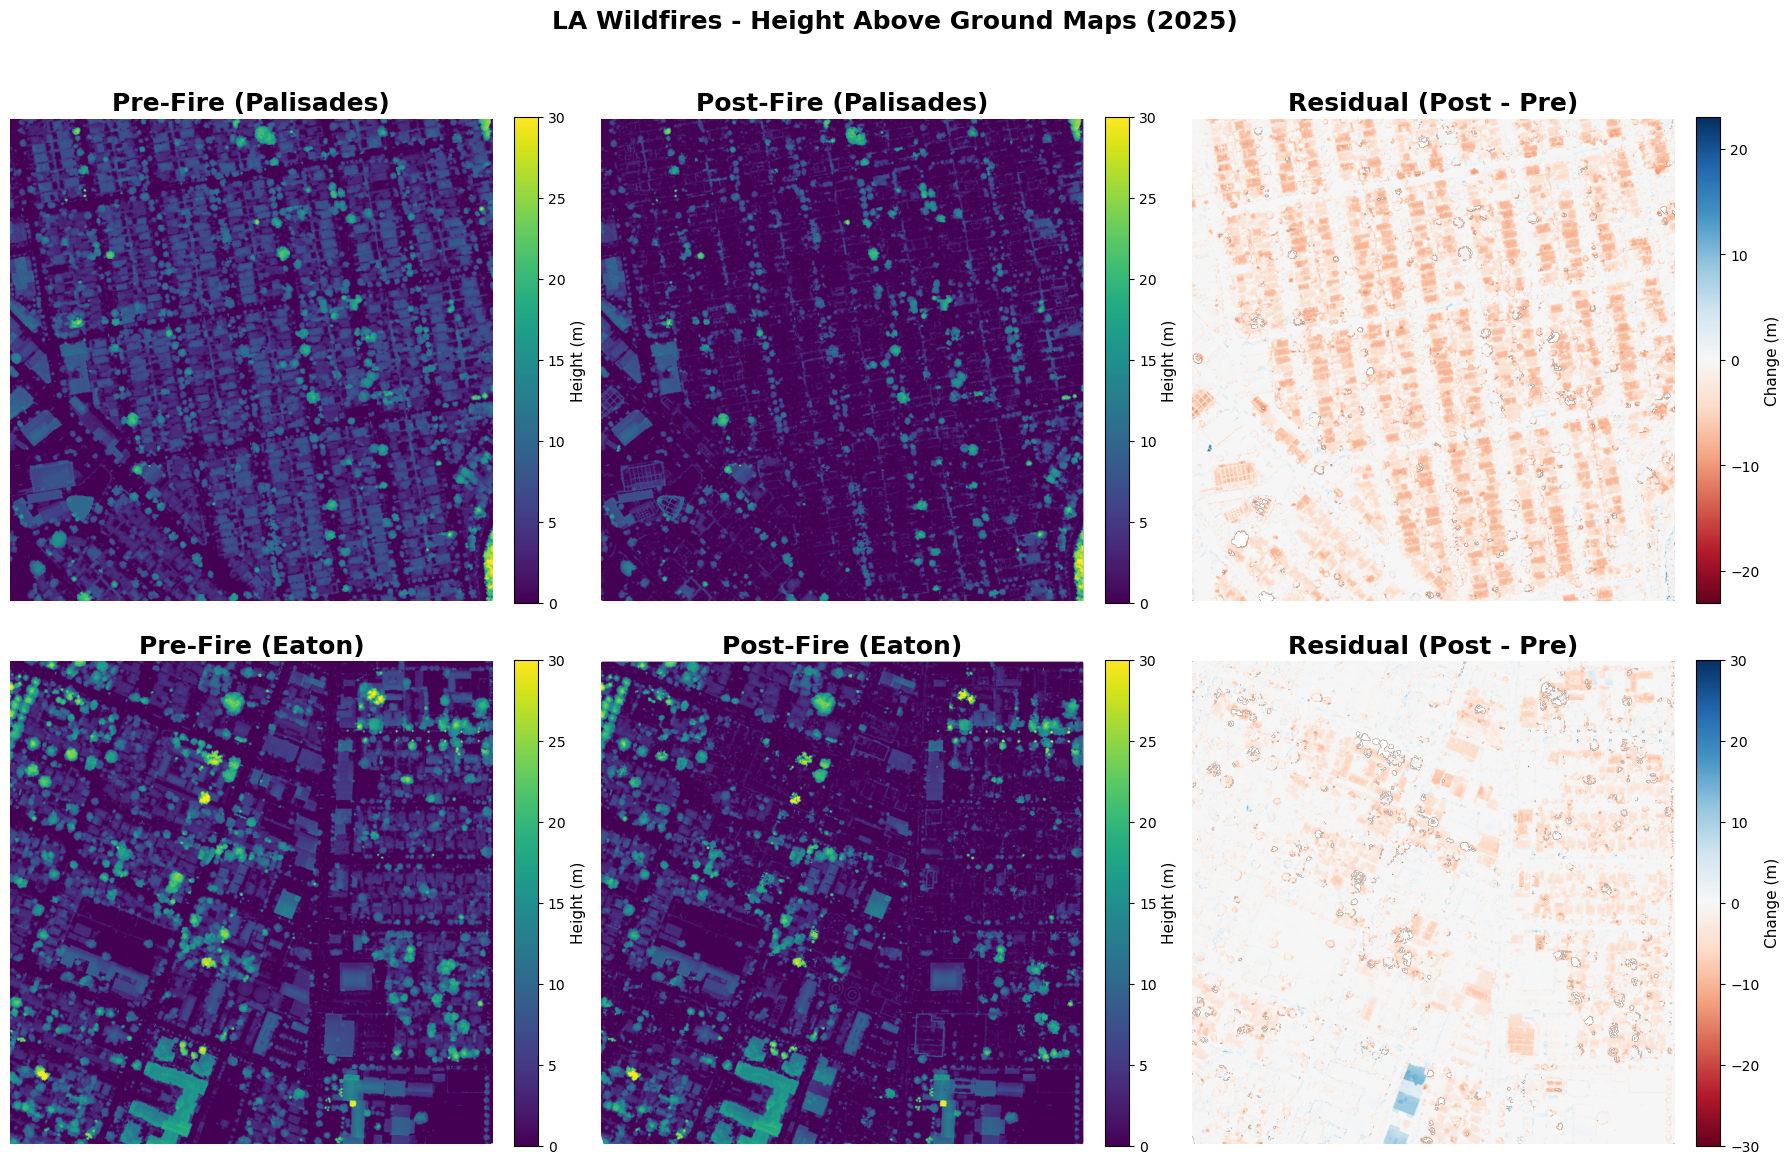

In [ ]:
"""
Wildfire Canopy Height Model Comparison
Creates a 2x3 panel visualization comparing pre-fire, post-fire, and residual CHMs
for the Palisades and Eaton fires in Southern California (2025)
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import tifffile
import imagecodecs

plt.style.use('default') 

# File paths
palisades_files = {
    'pre': '/Users/kkabasar/Downloads/CA_LosAngeles_B23_11SLT035900376800_topographic_cog_1m_clipped.tif',
    'post': '/Users/kkabasar/Downloads/USGS_LPC_CA_2025LosAngelesPostWildfire_C25_11SLT003592037680_topographic_cog_1m.tif',
    'residual': '/Users/kkabasar/Downloads/delta-chm-palisades.tif'
}

eaton_files = {
    'pre': '/Users/kkabasar/Downloads/CA_LosAngeles_B23_11SLT039500378300_topographic_cog_1m_clipped.tif',
    'post': '/Users/kkabasar/Downloads/USGS_LPC_CA_2025LosAngelesPostWildfire_C25_11SLT003952037830_topographic_cog_1m.tif',
    'residual': '/Users/kkabasar/Downloads/delta-chm-eaton.tif'
}

def load_chm(filepath, band_index=2, is_multiband=True):
    """
    Load CHM from GeoTIFF file with robust band handling.
    
    Parameters:
    -----------
    filepath : str
        Path to GeoTIFF file
    band_index : int
        Band index for CHM (default=2 for 3rd band, 0-indexed)
    is_multiband : bool
        Whether the file is multi-band (True) or single-band (False)
    
    Returns:
    --------
    numpy.ndarray : CHM data with NaN for invalid values
    """
    data = tifffile.imread(filepath)
    
    if is_multiband:
        # Check if bands are first or last dimension
        if len(data.shape) == 3:
            # Determine band dimension
            if data.shape[0] < data.shape[2]:
                # Bands are first dimension: (bands, height, width)
                chm = data[band_index, :, :]
            else:
                # Bands are last dimension: (height, width, bands)
                chm = data[:, :, band_index]
        else:
            chm = data
    else:
        # Single-band raster
        if len(data.shape) == 3:
            chm = np.squeeze(data)
        else:
            chm = data
    
    # Convert to float and handle NoData values
    chm = chm.astype(np.float32)
    chm[chm < -10] = np.nan  # NoData values (often -9999 or similar)
    chm[chm > 100] = np.nan  # Remove unrealistic canopy heights
    
    return chm

def create_fire_comparison_panel():
    """
    Create 2x3 panel comparing pre-fire, post-fire, and residual CHMs
    for Palisades and Eaton fires
    """
    print("\n" + "="*60)
    print("LOADING CHM DATA")
    print("="*60)
    
    # Load data for both fires
    print("\nLoading Palisades Fire CHMs...")
    palisades_pre = load_chm(palisades_files['pre'], band_index=2, is_multiband=True)
    palisades_post = load_chm(palisades_files['post'], band_index=2, is_multiband=True)
    palisades_residual = load_chm(palisades_files['residual'], band_index=0, is_multiband=False)
    
    print("Loading Eaton Fire CHMs...")
    eaton_pre = load_chm(eaton_files['pre'], band_index=2, is_multiband=True)
    eaton_post = load_chm(eaton_files['post'], band_index=2, is_multiband=True)
    eaton_residual = load_chm(eaton_files['residual'], band_index=0, is_multiband=False)
    
    # Create figure with 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LA Wildfires - Height Above Ground Maps (2025)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Define consistent color limits for CHM (pre and post)
    chm_vmin, chm_vmax = 0, 30  # Typical canopy height range in meters
    
    # Row 1: Palisades Fire
    # Pre-fire CHM
    im1 = axes[0, 0].imshow(palisades_pre, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[0, 0].set_title('Pre-Fire (Palisades)', fontsize=18, fontweight='bold')
    axes[0, 0].set_ylabel('Palisades Fire', fontsize=18, fontweight='bold', rotation=90, labelpad=10)
    axes[0, 0].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    cbar1.set_label('Height (m)', fontsize=11)
    
    # Post-fire CHM
    im2 = axes[0, 1].imshow(palisades_post, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[0, 1].set_title('Post-Fire (Palisades)', fontsize=18, fontweight='bold')
    axes[0, 1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    cbar2.set_label('Height (m)', fontsize=11)
    
    # Residual CHM (Post - Pre) - Inverted so red = height reduction
    residual_abs_max = np.nanmax(np.abs(palisades_residual))
    residual_limit = min(residual_abs_max, 30)  # Cap at 30m for better visualization
    norm = TwoSlopeNorm(vmin=-residual_limit, vcenter=0, vmax=residual_limit)
    im3 = axes[0, 2].imshow(palisades_residual, cmap='RdBu', norm=norm)  # Changed from RdBu_r to RdBu
    axes[0, 2].set_title('Residual (Post - Pre)', fontsize=18, fontweight='bold')
    axes[0, 2].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    cbar3.set_label('Change (m)', fontsize=11)
    
    # Row 2: Eaton Fire
    # Pre-fire CHM
    im4 = axes[1, 0].imshow(eaton_pre, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[1, 0].set_title('Pre-Fire (Eaton)', fontsize=18, fontweight='bold')
    axes[1, 0].set_ylabel('Eaton Fire', fontsize=18, fontweight='bold', rotation=90, labelpad=10)
    axes[1, 0].axis('off')
    cbar4 = plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
    cbar4.set_label('Height (m)', fontsize=11)
    
    # Post-fire CHM
    im5 = axes[1, 1].imshow(eaton_post, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[1, 1].set_title('Post-Fire (Eaton)', fontsize=18, fontweight='bold')
    axes[1, 1].axis('off')
    cbar5 = plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
    cbar5.set_label('Height (m)', fontsize=11)
    
    # Residual CHM (Post - Pre) - Inverted so red = height reduction
    residual_abs_max = np.nanmax(np.abs(eaton_residual))
    residual_limit = min(residual_abs_max, 30)
    norm = TwoSlopeNorm(vmin=-residual_limit, vcenter=0, vmax=residual_limit)
    im6 = axes[1, 2].imshow(eaton_residual, cmap='RdBu', norm=norm)  # Changed from RdBu_r to RdBu
    axes[1, 2].set_title('Residual (Post - Pre)', fontsize=18, fontweight='bold')
    axes[1, 2].axis('off')
    cbar6 = plt.colorbar(im6, ax=axes[1, 2], fraction=0.046, pad=0.04)
    cbar6.set_label('Change (m)', fontsize=11)

    plt.show()
    
if __name__ == "__main__":
    print("Creating wildfire CHM comparison visualization...")
    print("-" * 60)
    create_fire_comparison_panel()